# Import Libraries

In [1]:
import cv2
import os
import os.path as ops
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from easydict import EasyDict as edict
from collections import OrderedDict
from moviepy.editor import VideoFileClip

In [2]:
# ignore warning for tf 2.0
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
print(tf.__version__)

1.13.0-rc2


# Setting Data Set and Weights Path

In [4]:
weights_path = 'model/tusimple_lanenet/tusimple_lanenet_2019-03-29-17-16-18.ckpt-9999'

images_path = "data/input_images/test_image/"
images_list = os.listdir(images_path)

# Setting parameters

In [5]:
__C = edict()
cfg = __C

# Train options
__C.TRAIN = edict()
__C.TRAIN.TF_ALLOW_GROWTH = True

# Test options
__C.TEST = edict()
__C.TEST.GPU_USE = True
__C.TEST.GPU_MEMORY_FRACTION = 0.8


# CNN Base Function
## cnn_basenet.py

In [6]:
class CNNBaseModel(object):
    def __init__(self):
        pass

    @staticmethod
    def conv2d(inputdata, out_channel, kernel_size, padding='SAME',
               stride=1, w_init=None, b_init=None,
               split=1, use_bias=True, data_format='NHWC', name=None):
        with tf.variable_scope(name):
            in_shape = inputdata.get_shape().as_list()
            channel_axis = 3 if data_format == 'NHWC' else 1
            in_channel = in_shape[channel_axis]
            assert in_channel is not None, "[Conv2D] Input cannot have unknown channel!"
            assert in_channel % split == 0
            assert out_channel % split == 0

            padding = padding.upper()

            if isinstance(kernel_size, list):
                filter_shape = [kernel_size[0], kernel_size[1]] + [in_channel / split, out_channel]
            else:
                filter_shape = [kernel_size, kernel_size] + [in_channel / split, out_channel]

            if isinstance(stride, list):
                strides = [1, stride[0], stride[1], 1] if data_format == 'NHWC' \
                    else [1, 1, stride[0], stride[1]]
            else:
                strides = [1, stride, stride, 1] if data_format == 'NHWC' \
                    else [1, 1, stride, stride]

            if w_init is None:
                w_init = tf.contrib.layers.variance_scaling_initializer()
            if b_init is None:
                b_init = tf.constant_initializer()

            w = tf.get_variable('W', filter_shape, initializer=w_init)
            b = None

            if use_bias:
                b = tf.get_variable('b', [out_channel], initializer=b_init)

            if split == 1:
                conv = tf.nn.conv2d(inputdata, w, strides, padding, data_format=data_format)
            else:
                inputs = tf.split(inputdata, split, channel_axis)
                kernels = tf.split(w, split, 3)
                outputs = [tf.nn.conv2d(i, k, strides, padding, data_format=data_format)
                           for i, k in zip(inputs, kernels)]
                conv = tf.concat(outputs, channel_axis)

            ret = tf.identity(tf.nn.bias_add(conv, b, data_format=data_format)
                              if use_bias else conv, name=name)

        return ret

    @staticmethod
    def relu(inputdata, name=None):
        return tf.nn.relu(features=inputdata, name=name)

    @staticmethod
    def maxpooling(inputdata, kernel_size, stride=None, padding='VALID',
                   data_format='NHWC', name=None):
        padding = padding.upper()

        if stride is None:
            stride = kernel_size

        if isinstance(kernel_size, list):
            kernel = [1, kernel_size[0], kernel_size[1], 1] if data_format == 'NHWC' else \
                [1, 1, kernel_size[0], kernel_size[1]]
        else:
            kernel = [1, kernel_size, kernel_size, 1] if data_format == 'NHWC' \
                else [1, 1, kernel_size, kernel_size]

        if isinstance(stride, list):
            strides = [1, stride[0], stride[1], 1] if data_format == 'NHWC' \
                else [1, 1, stride[0], stride[1]]
        else:
            strides = [1, stride, stride, 1] if data_format == 'NHWC' \
                else [1, 1, stride, stride]

        return tf.nn.max_pool(value=inputdata, ksize=kernel, strides=strides, padding=padding,
                              data_format=data_format, name=name)

    @staticmethod
    def layerbn(inputdata, is_training, name):
        return tf.layers.batch_normalization(inputs=inputdata, training=is_training, name=name)

    @staticmethod
    def deconv2d(inputdata, out_channel, kernel_size, padding='SAME',
                 stride=1, w_init=None, b_init=None,
                 use_bias=True, activation=None, data_format='channels_last',
                 trainable=True, name=None):
        with tf.variable_scope(name):
            in_shape = inputdata.get_shape().as_list()
            channel_axis = 3 if data_format == 'channels_last' else 1
            in_channel = in_shape[channel_axis]
            assert in_channel is not None, "[Deconv2D] Input cannot have unknown channel!"

            padding = padding.upper()

            if w_init is None:
                w_init = tf.contrib.layers.variance_scaling_initializer()
            if b_init is None:
                b_init = tf.constant_initializer()

            ret = tf.layers.conv2d_transpose(inputs=inputdata, filters=out_channel,
                                             kernel_size=kernel_size,
                                             strides=stride, padding=padding,
                                             data_format=data_format,
                                             activation=activation, use_bias=use_bias,
                                             kernel_initializer=w_init,
                                             bias_initializer=b_init, trainable=trainable,
                                             name=name)

        return ret

# Defining model using conv2d, Relu and Maxpooling

## fcn_decoder.py

In [7]:
class FCNDecoder(CNNBaseModel):
    def __init__(self, phase):
        super(FCNDecoder, self).__init__()
        self._train_phase = tf.constant('train', dtype=tf.string)
        self._phase = phase
        self._is_training = self._init_phase()

    def _init_phase(self):
        return tf.equal(self._phase, self._train_phase)

    def decode(self, input_tensor_dict, decode_layer_list, name):
        ret = dict()

        with tf.variable_scope(name):
            # score stage 1
            input_tensor = input_tensor_dict[decode_layer_list[0]]['data']

            score = self.conv2d(inputdata=input_tensor, out_channel=64,
                                kernel_size=1, use_bias=False, name='score_origin')
            decode_layer_list = decode_layer_list[1:]
            for i in range(len(decode_layer_list)):
                deconv = self.deconv2d(inputdata=score, out_channel=64, kernel_size=4,
                                       stride=2, use_bias=False, name='deconv_{:d}'.format(i + 1))
                input_tensor = input_tensor_dict[decode_layer_list[i]]['data']
                score = self.conv2d(inputdata=input_tensor, out_channel=64,
                                    kernel_size=1, use_bias=False, name='score_{:d}'.format(i + 1))
                fused = tf.add(deconv, score, name='fuse_{:d}'.format(i + 1))
                score = fused

            deconv_final = self.deconv2d(inputdata=score, out_channel=64, kernel_size=16,
                                         stride=8, use_bias=False, name='deconv_final')

            score_final = self.conv2d(inputdata=deconv_final, out_channel=2,
                                      kernel_size=1, use_bias=False, name='score_final')

            ret['logits'] = score_final

        return ret

## vgg_encoder.py
https://github.com/machrisaa/tensorflow-vgg

In [8]:
class VGG16Encoder(CNNBaseModel):
    def __init__(self, phase):
        super(VGG16Encoder, self).__init__()
        self._train_phase = tf.constant('train', dtype=tf.string)
        self._test_phase = tf.constant('test', dtype=tf.string)
        self._phase = phase
        self._is_training = self._init_phase()

    def _init_phase(self):
        return tf.equal(self._phase, self._train_phase)

    def _conv_stage(self, input_tensor, k_size, out_dims, name,
                    stride=1, pad='SAME'):
        with tf.variable_scope(name):
            conv = self.conv2d(inputdata=input_tensor, out_channel=out_dims,
                               kernel_size=k_size, stride=stride,
                               use_bias=False, padding=pad, name='conv')

            bn = self.layerbn(inputdata=conv, is_training=self._is_training, name='bn')

            relu = self.relu(inputdata=bn, name='relu')

            return relu

    def encode(self, input_tensor, name):
        ret = OrderedDict()

        with tf.variable_scope(name):
            # conv stage 1
            conv_1_1 = self._conv_stage(input_tensor=input_tensor, k_size=3, out_dims=64, name='conv1_1')
            conv_1_2 = self._conv_stage(input_tensor=conv_1_1, k_size=3, out_dims=64, name='conv1_2')
            pool1 = self.maxpooling(inputdata=conv_1_2, kernel_size=2, stride=2, name='pool1')

            # conv stage 2
            conv_2_1 = self._conv_stage(input_tensor=pool1, k_size=3, out_dims=128, name='conv2_1')
            conv_2_2 = self._conv_stage(input_tensor=conv_2_1, k_size=3, out_dims=128, name='conv2_2')
            pool2 = self.maxpooling(inputdata=conv_2_2, kernel_size=2, stride=2, name='pool2')

            # conv stage 3
            conv_3_1 = self._conv_stage(input_tensor=pool2, k_size=3, out_dims=256, name='conv3_1')
            conv_3_2 = self._conv_stage(input_tensor=conv_3_1, k_size=3, out_dims=256, name='conv3_2')
            conv_3_3 = self._conv_stage(input_tensor=conv_3_2, k_size=3, out_dims=256, name='conv3_3')
            pool3 = self.maxpooling(inputdata=conv_3_3, kernel_size=2, stride=2, name='pool3')
            ret['pool3'] = dict()
            ret['pool3']['data'] = pool3
            ret['pool3']['shape'] = pool3.get_shape().as_list()

            # conv stage 4
            conv_4_1 = self._conv_stage(input_tensor=pool3, k_size=3, out_dims=512, name='conv4_1')
            conv_4_2 = self._conv_stage(input_tensor=conv_4_1, k_size=3, out_dims=512, name='conv4_2')
            conv_4_3 = self._conv_stage(input_tensor=conv_4_2, k_size=3, out_dims=512, name='conv4_3')
            pool4 = self.maxpooling(inputdata=conv_4_3, kernel_size=2, stride=2, name='pool4')
            ret['pool4'] = dict()
            ret['pool4']['data'] = pool4
            ret['pool4']['shape'] = pool4.get_shape().as_list()

            # conv stage 5
            conv_5_1 = self._conv_stage(input_tensor=pool4, k_size=3, out_dims=512, name='conv5_1')
            conv_5_2 = self._conv_stage(input_tensor=conv_5_1, k_size=3, out_dims=512, name='conv5_2')
            conv_5_3 = self._conv_stage(input_tensor=conv_5_2, k_size=3, out_dims=512, name='conv5_3')
            pool5 = self.maxpooling(inputdata=conv_5_3, kernel_size=2, stride=2, name='pool5')
            ret['pool5'] = dict()
            ret['pool5']['data'] = pool5
            ret['pool5']['shape'] = pool5.get_shape().as_list()

        return ret

## lanenet_merge_model.py

In [9]:
class LaneNet():
    def __init__(self, phase):
        super(LaneNet, self).__init__()
        self._encoder = VGG16Encoder(phase=phase)
        self._decoder = FCNDecoder(phase=phase)
        return

    def __str__(self):
        info = 'Semantic Segmentation use {:s} as basenet to encode'.format(self._net_flag)
        return info

    def _build_model(self, input_tensor, name):
        with tf.variable_scope(name):
            # first encode
            encode_ret = self._encoder.encode(input_tensor=input_tensor,
                                              name='encode')

            # second decode
            decode_ret = self._decoder.decode(input_tensor_dict=encode_ret,
                                              name='decode',
                                              decode_layer_list=['pool5',
                                                                 'pool4',
                                                                 'pool3'])
            return decode_ret

    def inference(self, input_tensor, name):
        with tf.variable_scope(name):
            # Forward propagation to get logits
            inference_ret = self._build_model(input_tensor=input_tensor, name='inference')
            # Calculate the binary partition loss function
            decode_logits = inference_ret['logits']
            binary_seg_ret = tf.nn.softmax(logits=decode_logits)
            binary_seg_ret = tf.argmax(binary_seg_ret, axis=-1)

            return binary_seg_ret

# Processing Images

In [10]:
class LaneDetection():
    def __init__(self):
        # Lane Net
        phase_tensor = tf.constant('test', tf.string)
        net = LaneNet(phase=phase_tensor)
        self.input_tensor = tf.placeholder(dtype=tf.float32, shape=[1, 256, 512, 3], name='input_tensor')
        self.binary_seg_ret = net.inference(input_tensor=self.input_tensor, name='lanenet_model')

        # Set sess configuration
        CFG = cfg
        if CFG.TEST.GPU_USE:
            sess_config = tf.ConfigProto(device_count={'GPU': 1})
        else:
            sess_config = tf.ConfigProto(device_count={'CPU': 8})
        sess_config.gpu_options.per_process_gpu_memory_fraction = CFG.TEST.GPU_MEMORY_FRACTION
        sess_config.gpu_options.allow_growth = CFG.TRAIN.TF_ALLOW_GROWTH
        sess_config.gpu_options.allocator_type = 'BFC'

        # sess
        self.sess = tf.InteractiveSession(config=sess_config)

        # restore
        saver = tf.train.Saver()
        saver.restore(sess=self.sess, save_path=weights_path)
        
        self.trans_mat33, self.trans_mat33_r = self.setPerspectiveTransform()

        return

    def calc_quad(self, top_left, top_right, bottom_left, bottom_right, width=1280, height=720):
        top_height = (top_left[1] + top_right[1]) / 2.0 / height
        bottom_height = (bottom_left[1] + bottom_right[1]) / 2.0 / height
        top_width = (top_right[0] - top_left[0]) / width
        bottom_width = (bottom_right[0] - bottom_left[0]) / width

        quad = [[width / 2.0 * (1.0 - top_width), height * top_height],          # top left
                [width / 2.0 * (1.0 - bottom_width), height * bottom_height],    # bottom left
                [width / 2.0 * (1.0 + bottom_width), height * bottom_height],    # bottom right
                [width / 2.0 * (1.0 + top_width), height * top_height]]          # top right

        return np.float32(quad)

    def setPerspectiveTransform(self):
        src = self.calc_quad(top_left=[609, 341], top_right=[632, 344], \
                             bottom_left=[305, 528], bottom_right=[915, 521])
        dst = self.calc_quad(top_left=[655, 238], top_right=[670, 235], \
                             bottom_left=[121, 719], bottom_right=[1179, 716])

        return cv2.getPerspectiveTransform(src, dst), cv2.getPerspectiveTransform(dst, src)

    def transformImage(self, image, M, flags=cv2.INTER_NEAREST):
        img_size = (image.shape[1], image.shape[0])
        return cv2.warpPerspective(image, M, img_size, flags=flags)

    def combine(self, image, image_thr):
        # prepare rgb
        image_thr_mid_w = np.dstack((image_thr*255, image_thr*255, image_thr*255))
        image_thr_mid_r = np.dstack((image_thr*255, image_thr*0, image_thr*0))

        # combine    
        image_thr_mid_w = cv2.bitwise_not(image_thr_mid_w)
        image_and = cv2.bitwise_and(image, image_thr_mid_w)
        image_final = cv2.addWeighted(image_and, 1.0, image_thr_mid_r, 1.0, 0)
        
        return image_final

    def processing(self, image):
        # resize
        image_resize = cv2.resize(image, (512, 256), interpolation=cv2.INTER_LINEAR) 
        VGG_MEAN = [103.939, 116.779, 123.68]
        image_input = image_resize - VGG_MEAN

        # run
        binary_seg_image = self.sess.run(self.binary_seg_ret, feed_dict={self.input_tensor: [image_input]})
        image_net = binary_seg_image[0].astype(np.uint8)

        # resize
        image_net_s = cv2.resize(image_net, (1280, 720), interpolation=cv2.INTER_LINEAR)

        # combine
        image_final = self.combine(image, image_net_s)

        return image_final

    def stop(self):
        self.sess.close()


In [11]:
def show_image(images_list, i, image, cmap=None):
    if i == 0:
        fig=plt.figure(figsize=(15,15))
    plt.subplot(3, 2, i+1)
    plt.title(images_list[i])
    plt.imshow(image, cmap=cmap)

In [12]:
ld = LaneDetection()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



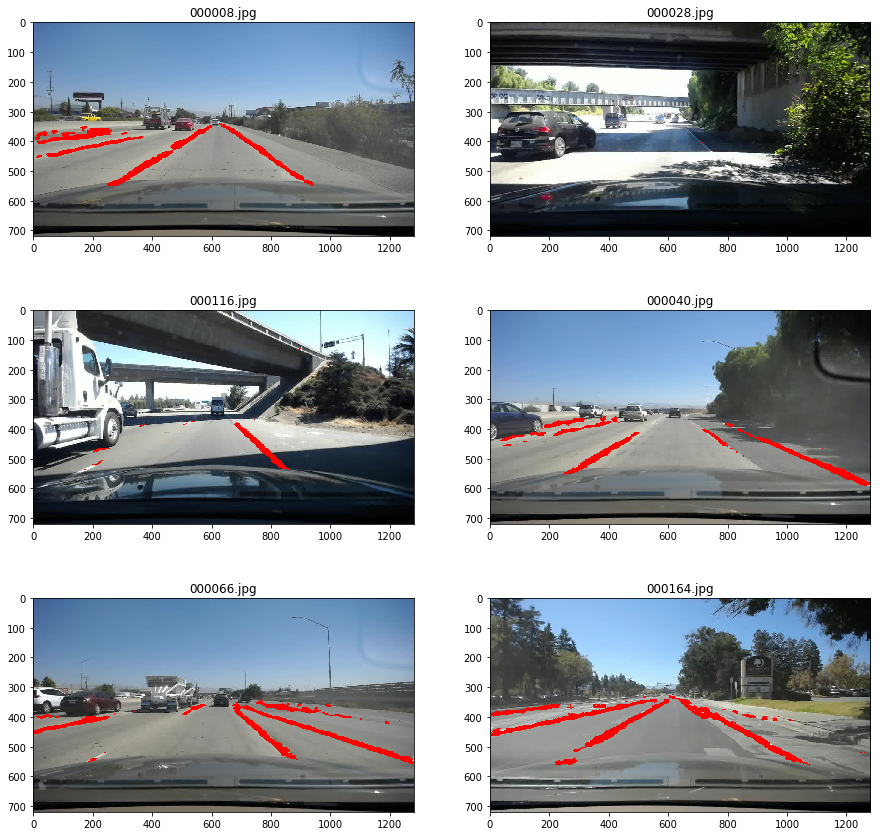

In [13]:
for i in range(len(images_list)):
    image = mpimg.imread(images_path + images_list[i])
    image_final = ld.processing(image)
    show_image(images_list, i, image_final)

# Processing Video

In [14]:
# input_path = 'data/input_videos/20180910_124456_input_freeway.mp4'

# start_time = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime(time.time()))
# output_path = 'data/output_videos/04_{:s}_freeway.mp4'.format(str(start_time))

In [15]:
input_path = 'data/input_videos/20180914_015504_input_night.mp4'

start_time = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime(time.time()))
output_path = 'data/output_videos/04_{:s}_night.mp4'.format(str(start_time))

In [16]:
clip1 = VideoFileClip(input_path)
white_clip = clip1.fl_image(lambda x: ld.processing(x))
%time white_clip.write_videofile(output_path, audio=True)

t:   0%|          | 5/7425 [00:00<02:32, 48.54it/s, now=None]

Moviepy - Building video data/output_videos/04_2019-03-30-10-23-14_night.mp4.
Moviepy - Writing video data/output_videos/04_2019-03-30-10-23-14_night.mp4



Moviepy - Done !
Moviepy - video ready data/output_videos/04_2019-03-30-10-23-14_night.mp4
CPU times: user 5min 20s, sys: 1min 16s, total: 6min 36s
Wall time: 3min 14s


In [17]:
ld.stop()